# Projet data - alternative au stage de fin de formation

## G-Research Crypto Forecasting

https://www.kaggle.com/c/g-research-crypto-forecasting

<img src="crypto.png"/>

### Description des données

**`train.csv`**<br>
Le jeu de données d'entrainement.
- `timestamp`: Le timestamp de la ligne courante. Chaque timestamp correspond à une minute précise.
- `Asset_ID`: L'identifiant de la crypto-monnaie.
- `Count`: Le nombre d'opérations survenues dans la minute.
- `Open`: Le prix en USD au début de la minute.
- `High`: Le prix le plus haut en USD atteint durant la minute.
- `Low`: Le prix le plus bas en USD atteint durant la minute.
- `Close`: Le prix en USD à la fin de la minute.
- `Volume`: Le nombre d'unités échangées dans la minute.
- `VWAP`: Le prix moyen pondéré en fonction du volume pour la minute courante.
- `Target`: Le rendement résiduel sur les 15 dernières minutes.

**`example_test.csv`**<br>
Un exemple de jeu de données de test.

**`example_sample_submission.csv`**<br>
Un échantillon de `train.csv`.

**`asset_details.csv`**<br>
Contient le nom des crypto-monnaies et leur poids en fonction de leur identifiant (`Asset_ID`).

### Métrique d'évaluation

Il s'agit d'une **corrélation pondérée**.

In [1]:
def weighted_correlation(expected, predicted, weights):
    weights = np.ravel(weights)
    expected = np.ravel(expected)
    predicted = np.ravel(predicted)
    sum_weights = np.sum(weights)
    mean_expected = np.sum(expected * weights) / sum_weights
    mean_predicted = np.sum(predicted * weights) / sum_weights
    var_expected = np.sum(weights * np.square(expected - mean_expected)) / sum_weights
    var_predicted = np.sum(weights * np.square(predicted - mean_predicted)) / sum_weights
    cov = np.sum((expected * predicted * weights)) / np.sum(weights) - mean_expected * mean_predicted
    corr = cov / np.sqrt(var_expected * var_predicted)
    return corr

### Exploration des données

In [47]:
import numpy as np
import pandas as pd
import pickle as pk
import matplotlib.pyplot as plt
import matplotlib.dates as md
import seaborn as sns
import datetime
import time
%matplotlib inline

#### Assets

In [3]:
assets = pd.read_csv("g-research-crypto-forecasting/asset_details.csv")
assets

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


#### Données d'entrainement

In [4]:
types = {
    "row_id": 'int32',
    "Asset_ID": 'int8',
    "Count": 'int32',
    "Open": 'float64',
    "High": 'float64',
    "Low": 'float64',
    "Close": 'float64',
    "Volume": 'float64',
    "VWAP": 'float64',
}

df = pd.read_csv("g-research-crypto-forecasting/train.csv", dtype=types)
df.head(10)

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40,2376.580000,2399.5000,2357.1400,2374.590000,19.233005,2373.116392,-0.004218
1,1514764860,0,5,8.530000,8.5300,8.5300,8.530000,78.380000,8.530000,-0.014399
2,1514764860,1,229,13835.194000,14013.8000,13666.1100,13850.176000,31.550062,13827.062093,-0.014643
3,1514764860,5,32,7.659600,7.6596,7.6567,7.657600,6626.713370,7.657713,-0.013922
4,1514764860,7,5,25.920000,25.9200,25.8740,25.877000,121.087310,25.891363,-0.008264
5,1514764860,6,173,738.302500,746.0000,732.5100,738.507500,335.987856,738.839291,-0.004809
6,1514764860,9,167,225.330000,227.7800,222.9800,225.206667,411.896642,225.197944,-0.009791
7,1514764860,11,7,329.090000,329.8800,329.0900,329.460000,6.635710,329.454118,NaN
8,1514764920,2,53,2374.553333,2400.9000,2354.2000,2372.286667,24.050259,2371.434498,-0.004079
9,1514764920,0,7,8.530000,8.5300,8.5145,8.514500,71.390000,8.520215,-0.015875


##### Info

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24236806 entries, 0 to 24236805
Data columns (total 10 columns):
 #   Column     Dtype  
---  ------     -----  
 0   timestamp  int64  
 1   Asset_ID   int8   
 2   Count      int32  
 3   Open       float64
 4   High       float64
 5   Low        float64
 6   Close      float64
 7   Volume     float64
 8   VWAP       float64
 9   Target     float64
dtypes: float64(7), int32(1), int64(1), int8(1)
memory usage: 1.6 GB


##### Description

In [6]:
df.describe()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
count,2.423681e+07,2.423681e+07,2.423681e+07,2.423681e+07,2.423681e+07,2.423681e+07,2.423681e+07,2.423681e+07,2.423680e+07,2.348647e+07
mean,1.577120e+09,6.292544e+00,2.864593e+02,1.432640e+03,1.436350e+03,1.429568e+03,1.432640e+03,2.868530e+05,NaN,7.121752e-06
std,3.323350e+07,4.091861e+00,8.673982e+02,6.029605e+03,6.039482e+03,6.020261e+03,6.029611e+03,2.433935e+06,NaN,5.679042e-03
min,1.514765e+09,0.000000e+00,1.000000e+00,1.170400e-03,1.195000e-03,2.000000e-04,1.171400e-03,-3.662812e-01,-inf,-5.093509e-01
25%,1.549011e+09,3.000000e+00,1.900000e+01,2.676500e-01,2.681600e-01,2.669000e-01,2.676483e-01,1.410725e+02,2.676368e-01,-1.694354e-03
50%,1.578372e+09,6.000000e+00,6.400000e+01,1.428860e+01,1.431250e+01,1.426300e+01,1.428920e+01,1.295415e+03,1.428769e+01,-4.289844e-05
75%,1.606198e+09,9.000000e+00,2.210000e+02,2.288743e+02,2.293000e+02,2.284200e+02,2.288729e+02,2.729764e+04,2.288728e+02,1.601520e-03
max,1.632182e+09,1.300000e+01,1.650160e+05,6.480594e+04,6.490000e+04,6.467053e+04,6.480854e+04,7.597554e+08,inf,9.641699e-01


##### Valeurs manquantes, infinies et doublons

In [11]:
na_values = df.isna().sum()
inf_values = df.shape[0] - np.isfinite(df).sum() - na_values
pd.DataFrame(data=[na_values, inf_values], index=["N/A", "Inf"]).T

,N/A,Inf
timestamp,0,0
Asset_ID,0,0
Count,0,0
Open,0,0
High,0,0
Low,0,0
Close,0,0
Volume,0,0
VWAP,0,0
Target,0,0


In [8]:
print("Duplicates:", df.duplicated().sum())

Duplicates: 0


<u>Résumé du jeu de données d'entrainement :</u>
- 24 236 806 lignes
- 10 colonnes, toutes numériques
- Pas de doublon
- Quelques N/A et inf dans `VWAP` et 3% de N/A dans `Target` : utilisons une interpolation pour combler les trous.

In [10]:
df = df.replace([np.inf, -np.inf], np.nan).ffill().bfill()

### Visualisation

Le jeu de données d'entrainement contient les données des 14 crypto-monnaies. Commençons par observer la distribution de chacune :

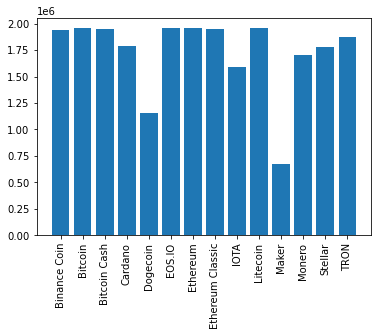

In [12]:
count_by_asset = df.groupby("Asset_ID").count().reset_index()
asset_ids = count_by_asset["Asset_ID"].unique()
plt.bar(x="Asset_ID", height="Count", data=count_by_asset)
plt.xticks(ticks=asset_ids, labels=[assets[assets["Asset_ID"] == asset_id]["Asset_Name"].values[0] for asset_id in asset_ids], rotation=90)
plt.show()

Intéressons-nous en détail à l'une d'entre elles : le **Bitcoin** (`Asset_ID == 1`)

In [13]:
df_bitcoin = df[df["Asset_ID"] == 1].set_index("timestamp")
df_bitcoin.describe()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
count,1956282.0,1.956282e+06,1.956282e+06,1.956282e+06,1.956282e+06,1.956282e+06,1.956282e+06,1.956282e+06,1.956282e+06
mean,1.0,1.082390e+03,1.561112e+04,1.565181e+04,1.557804e+04,1.561112e+04,9.284999e+01,1.561100e+04,-1.627027e-06
std,0.0,1.601813e+03,1.512141e+04,1.513203e+04,1.510627e+04,1.512144e+04,1.554052e+02,1.512129e+04,2.014746e-03
min,1.0,1.000000e+00,3.149657e+03,3.176910e+03,3.120000e+03,3.151545e+03,1.000000e-04,3.152326e+03,-7.255649e-02
25%,1.0,2.980000e+02,6.848250e+03,6.865382e+03,6.835622e+03,6.848072e+03,3.020642e+01,6.848265e+03,-8.163928e-04
50%,1.0,5.630000e+02,9.206021e+03,9.222400e+03,9.191175e+03,9.205980e+03,5.280397e+01,9.205946e+03,-1.917365e-05
75%,1.0,1.259000e+03,1.346695e+04,1.352072e+04,1.340000e+04,1.346706e+04,9.767651e+01,1.346745e+04,7.720001e-04
max,1.0,8.747800e+04,6.480594e+04,6.490000e+04,6.467053e+04,6.480854e+04,1.040500e+04,6.479982e+04,9.278919e-02


Voyons l'étendue temporelle des données, et regardons si nous avons des données pour chaque minute :

In [14]:
print("Les données concernant le Bitcoin vont du", df_bitcoin.index[0].astype('datetime64[s]'), "au", df_bitcoin.index[-1].astype('datetime64[s]'))
print("Durant ce laps de temps, il y a eu :")
gaps = (df_bitcoin.index[1:] - df_bitcoin.index[:-1]).value_counts().sort_index()
for gap, values in zip(gaps.index, gaps.values):
    if gap >= 120:
        print(values, "vide(s) de", (gap // 60) - 1, "minutes")

Les données concernant le Bitcoin vont du 2018-01-01T00:01:00 au 2021-09-21T00:00:00
Durant ce laps de temps, il y a eu :
78 vide(s) de 1 minutes
12 vide(s) de 2 minutes
11 vide(s) de 3 minutes
3 vide(s) de 4 minutes
4 vide(s) de 5 minutes
9 vide(s) de 6 minutes
3 vide(s) de 7 minutes
2 vide(s) de 8 minutes
4 vide(s) de 9 minutes
1 vide(s) de 10 minutes
3 vide(s) de 11 minutes
3 vide(s) de 13 minutes
1 vide(s) de 16 minutes
2 vide(s) de 17 minutes
1 vide(s) de 19 minutes
1 vide(s) de 23 minutes
1 vide(s) de 25 minutes
2 vide(s) de 26 minutes
2 vide(s) de 29 minutes
1 vide(s) de 36 minutes
1 vide(s) de 39 minutes


Pour palier à ce problème de "trous", nous pouvons les remplir avec un `ffill` en utilisant la dernière valeur valide.

In [15]:
df_bitcoin = df_bitcoin.reindex(np.array(range(df_bitcoin.index[0], df_bitcoin.index[-1] + 60, 60))).ffill()

Nous pouvons maintenant visualiser l'évolution du cours du Bitcoin en fonction du temps.

In [36]:
def timestamps_to_dates(timestamps):
    dates = [datetime.datetime.fromtimestamp(ts) for ts in timestamps]
    datenums = md.date2num(dates)
    plt.xticks(rotation=30)
    xfmt = md.DateFormatter('%Y-%m-%d')
    plt.gca().xaxis.set_major_formatter(xfmt)
    return datenums

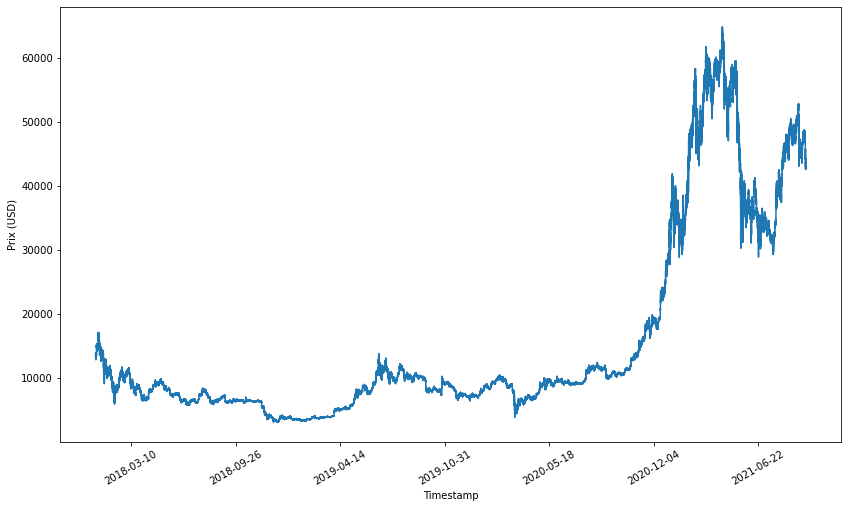

In [37]:
plt.figure(figsize=(14, 8))
plt.plot(timestamps_to_dates(df_bitcoin.index), df_bitcoin.Close)
plt.xlabel("Timestamp")
plt.ylabel("Prix (USD)")
plt.show()

Effectuons le même traitement pour les autres crypto-monnaies :

In [38]:
colors = {
    0: "tab:blue",
    1: "tab:orange",
    2: "tab:green",
    3: "tab:red",
    4: "tab:purple",
    5: "tab:brown",
    6: "tab:pink",
    7: "tab:gray",
    8: "tab:olive",
    9: "tab:cyan",
    10: "gold",
    11: "m",
    12: "crimson",
    13: "salmon",
}

In [39]:
def extract_asset_and_fill_gaps(df, asset_id):
    df_asset = df[df["Asset_ID"] == asset_id].set_index("timestamp")
    asset_begin = df_asset.index[0].astype('datetime64[s]')
    asset_end = df_asset.index[-1].astype('datetime64[s]')
    df_asset = df_asset.reindex(np.array(range(df_asset.index[0], df_asset.index[-1] + 60, 60))).ffill()
    return df_asset, asset_begin, asset_end

In [40]:
d_assets = {}
for i, row in assets.iterrows():
    asset_id = row["Asset_ID"]
    asset_name = row["Asset_Name"]
    df_asset, asset_begin, asset_end = extract_asset_and_fill_gaps(df, asset_id)
    d_assets[asset_id] = {
        "Asset_ID": asset_id,
        "Asset_Name": asset_name,
        "Asset_Data": df_asset,
        "Asset_Begin": asset_begin,
        "Asset_End": asset_end,
    }

Etendue temporelle du Bitcoin Cash     : du 2018-01-01T00:01:00 au 2021-09-21T00:00:00
Etendue temporelle du Binance Coin     : du 2018-01-01T00:01:00 au 2021-09-21T00:00:00
Etendue temporelle du Bitcoin          : du 2018-01-01T00:01:00 au 2021-09-21T00:00:00
Etendue temporelle du EOS.IO           : du 2018-01-01T00:01:00 au 2021-09-21T00:00:00
Etendue temporelle du Ethereum Classic : du 2018-01-01T00:01:00 au 2021-09-21T00:00:00
Etendue temporelle du Ethereum         : du 2018-01-01T00:01:00 au 2021-09-21T00:00:00
Etendue temporelle du Litecoin         : du 2018-01-01T00:01:00 au 2021-09-21T00:00:00
Etendue temporelle du Monero           : du 2018-01-01T00:01:00 au 2021-09-21T00:00:00
Etendue temporelle du TRON             : du 2018-02-06T21:37:00 au 2021-09-21T00:00:00
Etendue temporelle du Stellar          : du 2018-02-16T23:53:00 au 2021-09-21T00:00:00
Etendue temporelle du Cardano          : du 2018-04-17T09:11:00 au 2021-09-21T00:00:00
Etendue temporelle du IOTA             : du

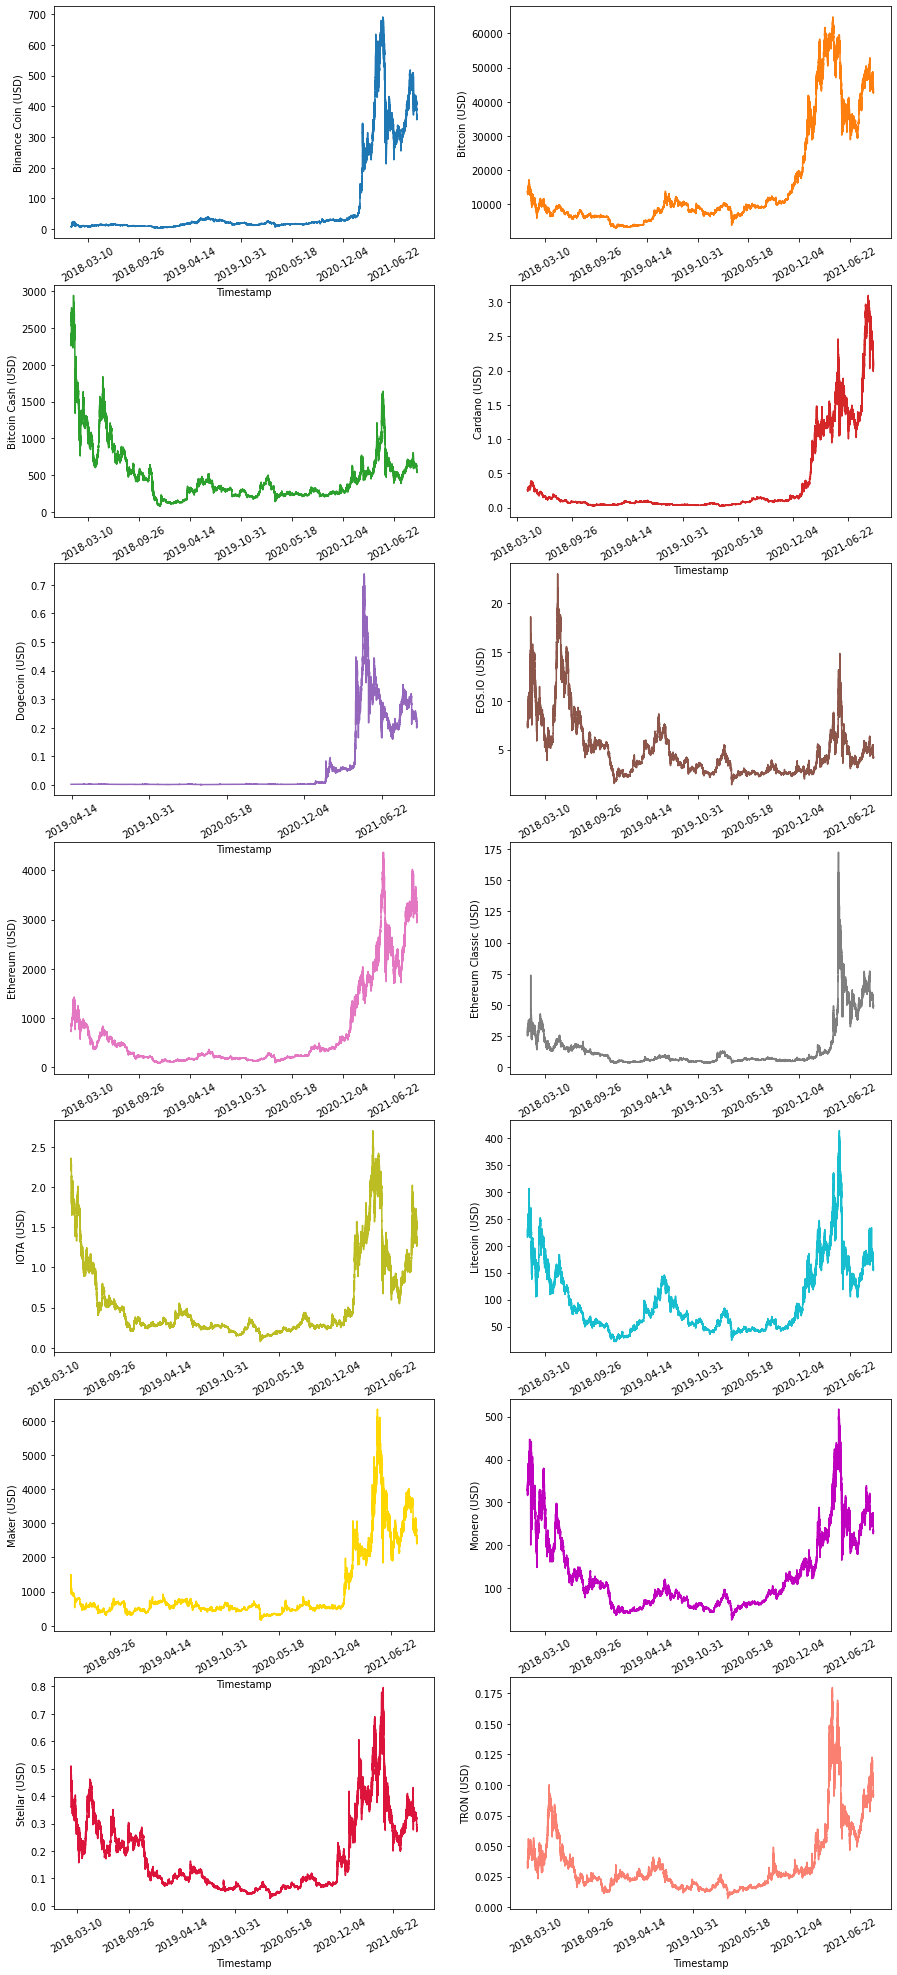

In [41]:
plt.figure(figsize=(15, 5 * len(d_assets) // 2))
for asset in d_assets.values():
    print("Etendue temporelle du %-16s" % asset["Asset_Name"], ": du", asset["Asset_Begin"], "au", asset["Asset_End"])
    plt.subplot(len(d_assets) // 2, 2, asset["Asset_ID"] + 1)
    plt.plot(timestamps_to_dates(asset["Asset_Data"].index), asset["Asset_Data"].Close, color=colors[asset["Asset_ID"]])
    plt.xlabel("Timestamp")
    plt.ylabel(asset["Asset_Name"] + " (USD)")
plt.show()

Certaines crypto-monnaies semblent corrélées à première vue, mais **l'étendue temporelle n'est pas la même pour toutes les crypto-monnaies**. Par exemple, le **Dogecoin** n'a pas de données avant le 12 Avril 2019.<br>
Réduisons l'intervalle de temps à la dernière année : du 20 Septembre 2020 à la même date en 2021.

In [42]:
def date_to_timestamp(date):
    return np.int32(time.mktime(datetime.datetime.strptime(date, "%Y-%m-%d").timetuple()))

In [43]:
d_assets_1_year = {}
for asset in d_assets.values():
    d_assets_1_year[asset["Asset_ID"]] = {
        "Asset_ID": asset["Asset_ID"],
        "Asset_Name": asset["Asset_Name"],
        "Asset_Data": asset["Asset_Data"].loc[date_to_timestamp("2020-09-20"):date_to_timestamp("2021-09-20")],
    }

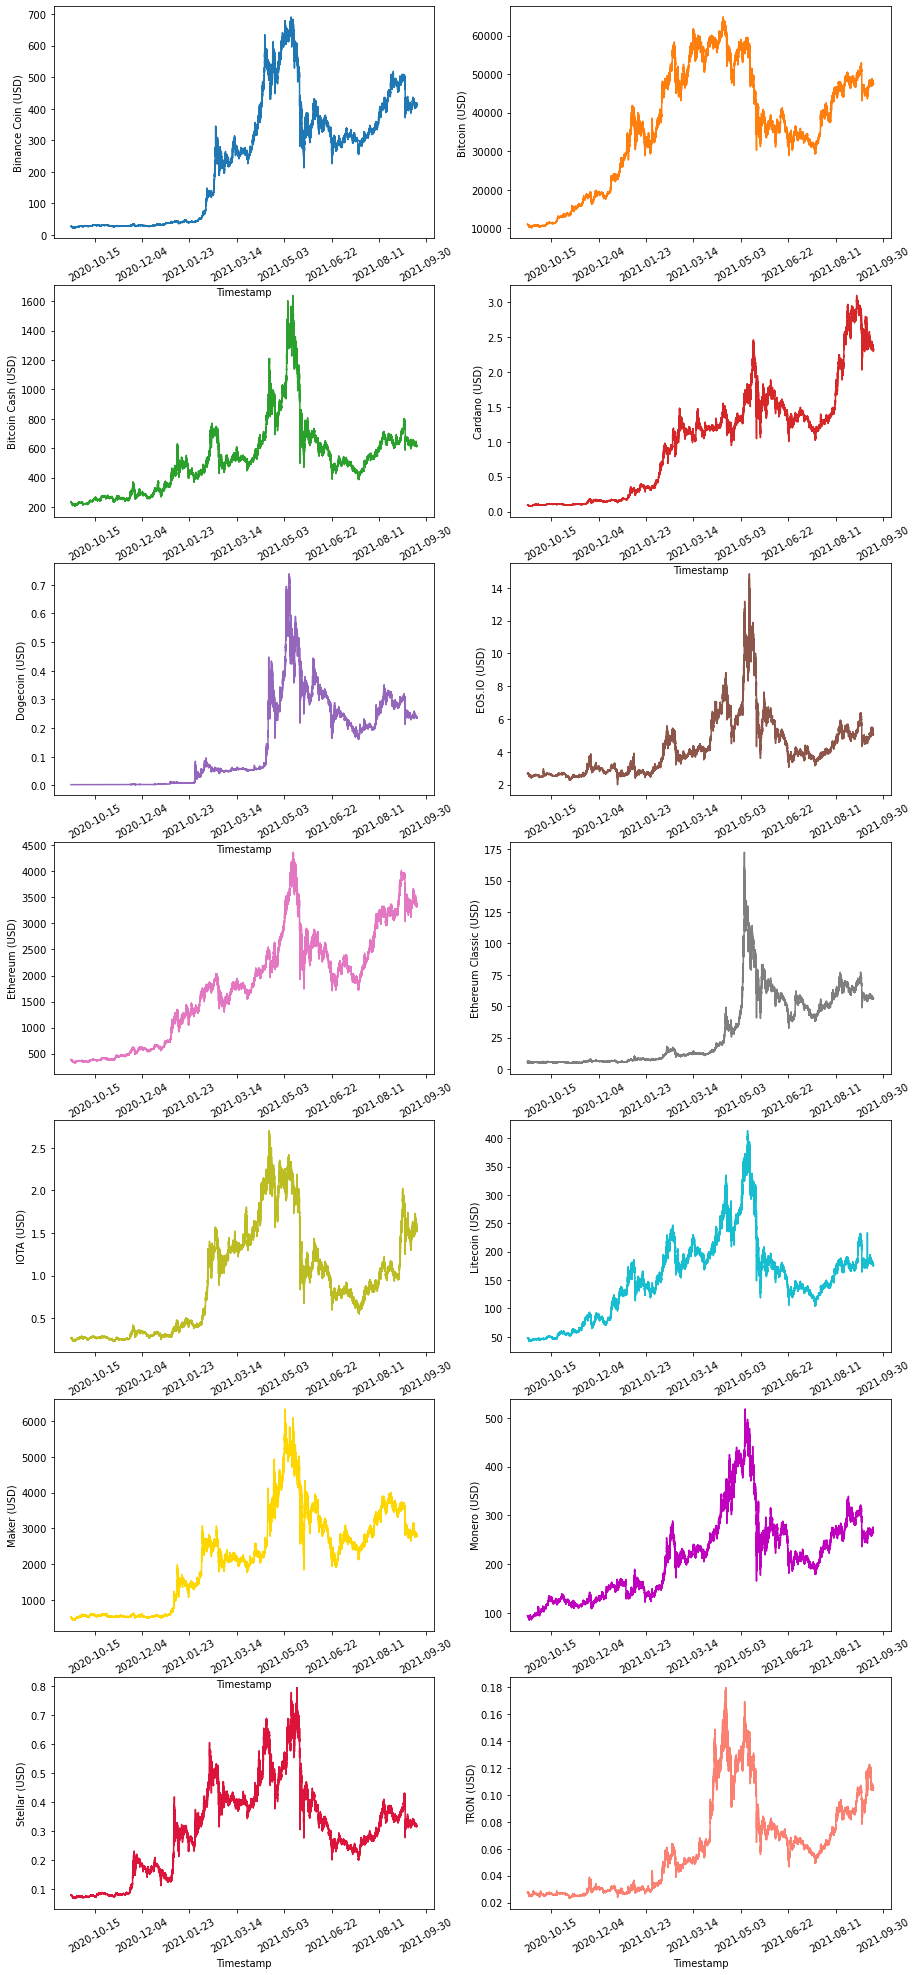

In [44]:
plt.figure(figsize=(15, 5 * len(d_assets) // 2))
for asset in d_assets_1_year.values():
    plt.subplot(len(d_assets_1_year) // 2, 2, asset["Asset_ID"] + 1)
    plt.plot(timestamps_to_dates(asset["Asset_Data"].index), asset["Asset_Data"].Close, color=colors[asset["Asset_ID"]])
    plt.xlabel("Timestamp")
    plt.ylabel(asset["Asset_Name"] + " (USD)")
plt.show()

En se basant uniquement sur les données de la dernière année, nous pouvons voir des fluctuations similaires entre chaque crypto-monnaie, avec notamment un pic important vers **Mai 2021**. Il semble bien exister une corrélation entre chaque crypto-monnaie.

In [45]:
df_assets_1_year = pd.DataFrame()
for asset in d_assets_1_year.values():
    df_assets_1_year = df_assets_1_year.join(asset["Asset_Data"].Close, rsuffix=asset["Asset_Name"], how="outer")
df_assets_1_year.columns = [asset["Asset_Name"] for asset in d_assets_1_year.values()]
df_assets_1_year.head(5)

,Bitcoin Cash,Binance Coin,Bitcoin,EOS.IO,Ethereum Classic,Ethereum,Litecoin,Monero,TRON,Stellar,Cardano,IOTA,Maker,Dogecoin
timestamp,,,,,,,,,,,,,,
1600552800,233.2850,27.30840,11048.891429,2.695525,5.230100,384.962857,48.37725,94.475,0.027885,0.078807,0.091587,0.27290,515.475000,0.002796
1600552860,233.2900,27.32445,11044.790000,2.695700,5.553067,384.801667,48.36000,94.430,0.027920,0.078819,0.091526,0.27280,515.503525,0.002795
1600552920,233.2125,27.27730,11037.047143,2.694700,5.458550,384.174286,48.34500,94.439,0.027875,0.078755,0.091467,0.27235,515.350000,0.002795
1600552980,233.1875,27.25110,11036.952259,2.694175,5.541767,384.398333,48.32000,94.439,0.027884,0.078580,0.091511,0.27235,515.340000,0.002797
1600553040,233.1675,27.25870,11039.687143,2.694860,5.184000,384.456667,48.34725,94.380,0.027901,0.078518,0.091476,0.27235,515.362500,0.002799


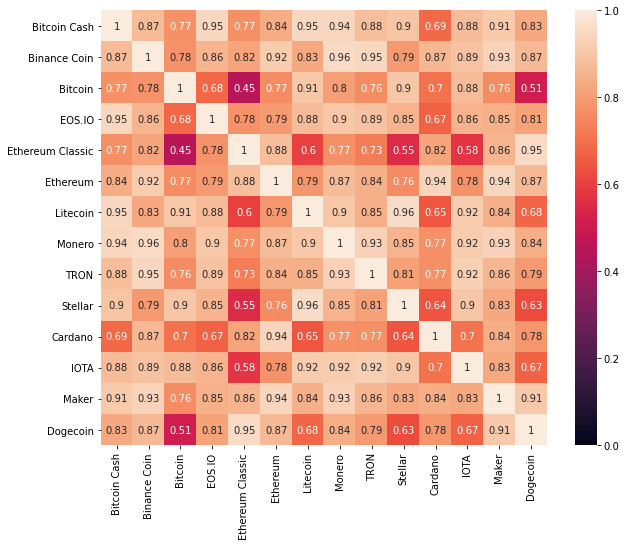

In [46]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_assets_1_year.corr(), vmin=0, vmax=1, annot=True)
plt.show()

In [49]:
def save_data(filename, *objects):
    with open("./" + filename + ".pkl", 'wb') as f:
        pickler = pk.Pickler(f)
        for obj in objects:
            pickler.dump(obj)

In [51]:
save_data("crypto_df", df)
save_data("crypto_d_assets_1_year", d_assets_1_year)